# 8.1 Processing raw data
This section combines the raw data, the adjustments and cleaned bars to get processed 1-minute data. After processing we also detect the halts to create a <code>halted</code> flag. There are no gaps for processed data. All stocks that are active on a certain day have minute bars for every minute, from pre to post market, even if no trades took place. Empty bars are forward filled. Only for the first day, backwards filling may be done. All processed data will have the following columns: <code>['open', 'high', 'low', 'close', 'close_original', 'volume', 'tradeable', 'halted']</code>. The 'close_original' is the unadjusted price. This is needed for filtering, e.g. only the stocks above $1.

The steps:
1. The bars are cleaned first, because the cleaned data is derived from raw tick data.
2. Then the cleaned bars are split and dividend adjusted. (Split adjustment is done first for bars and dividends, then the split-adjusted bars are dividend-adjusted using the split-adjusted dividends.)
3. After this, the data is forward filled. If there are still NA values, the data is backward filled. Forward/backward filled bars are flagged by setting <code>tradeable</code> to False.
4. Lastly, halts are detected to create the <code>halted</code> flag.
5. The true start/end dates are determined for each stock.

To make the loop more readable, we will first build the functions <code>split_adjust</code>, <code>dividend_adjust</code> and <code>detect_halts</code>.

In [2]:
from utils import get_tickers, get_market_calendar
from datetime import datetime, date, time
import mplfinance as mpf
import pandas as pd
import numpy as np
import os
DATA_PATH = "../data/polygon/"

# 8.2 Split adjustment

In [3]:
adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/TSLA.csv", parse_dates=True, index_col=0)
bars = pd.read_parquet(DATA_PATH + f"raw/m1/TSLA-2019-01-01.parquet")

adjustments.index = pd.to_datetime(adjustments.index).date
splits = adjustments[adjustments.type == "SPLIT"].copy()

In [4]:
splits

,type,subtype,amount
2020-08-31,SPLIT,N,0.200000
2022-08-25,SPLIT,N,0.333333


In [5]:
trading_dates_ticker = np.unique(bars.index.date)

# The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
splits = splits.drop(columns=['type', 'subtype', 'amount'])
splits

,cumulative_adjustment
2020-08-31,0.066667
2022-08-25,0.333333


In [6]:
splits.index = splits.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [7]:
splits[splits.index > date(2019, 3, 26)][:5]

,cumulative_adjustment
2019-03-27,0.066667
2019-03-28,0.066667
2019-03-29,0.066667
2019-04-01,0.066667
2019-04-02,0.066667


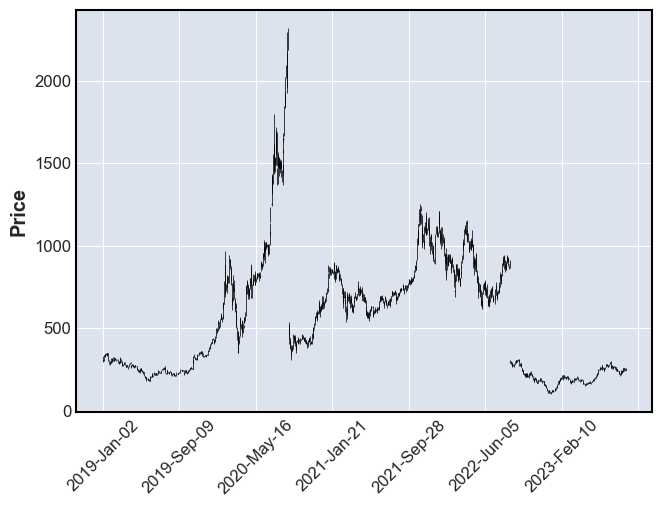

In [8]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [9]:
bars['date'] = bars.index.date
bars = bars.merge(splits, left_on='date', right_index=True, how='left')
bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")
bars['close_original'] = bars['close']

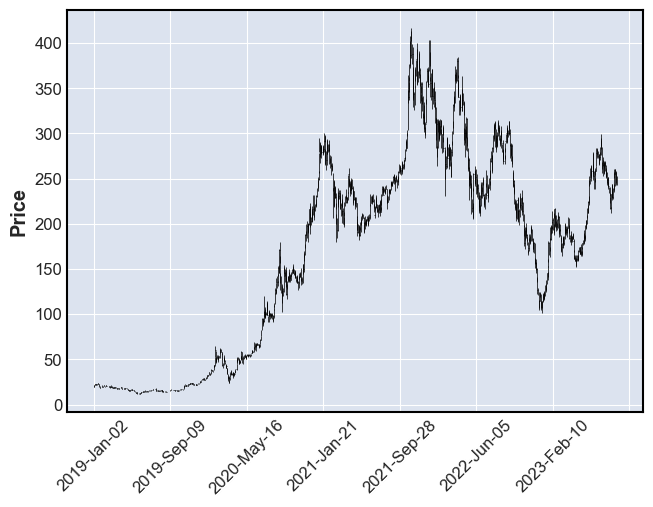

In [10]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

We also have to split-adjust the dividends, if there are splits. (Try to use the ticker BBD. Tesla has no dividends.)

In [11]:
dividends = adjustments[adjustments.type == "DIV"].copy()
dividends.head(3)

,type,subtype,amount


In [12]:
dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
dividends.index.names = ['ex_div_date']
dividends = dividends[['cum_div_date', 'amount']]
dividends = dividends.merge(splits, left_on='cum_div_date', right_index=True, how='left')
dividends['amount'] = dividends['amount'].multiply(dividends["cumulative_adjustment"], axis="index")
dividends.drop(columns=['cumulative_adjustment'], inplace=True)

In [13]:
dividends.head(3)

,cum_div_date,amount
ex_div_date,,


Putting it all together in a function yields:

In [14]:
def split_adjust(bars, ticker):
    """
    Returns the split-adjusted bars AND dividends.
    If there is no split-data, the original bars are returned.
    If there is no dividend-data, None is returned. Else we return the split-adjusted dividends with a new column "cum_div_date".
    """

    if os.path.isfile(DATA_PATH + f"raw/adjustments/{ticker}.csv"):
        bars['close_original'] = bars['close']
        
        adjustments = pd.read_csv(DATA_PATH + f"raw/adjustments/{ticker}.csv", parse_dates=True, index_col=0)

        adjustments.index = pd.to_datetime(adjustments.index).date

        trading_dates_ticker = np.unique(bars.index.date)

        adjustments = adjustments[(adjustments.index > trading_dates_ticker[0]) & (adjustments.index <= trading_dates_ticker[-1])]

        splits = adjustments[adjustments.type == "SPLIT"].copy()
        dividends = adjustments[adjustments.type == "DIV"].copy()

        # Adjust for splits
        if not splits.empty:
            splits['cumulative_adjustment'] = splits['amount'][::-1].cumprod()
            splits = splits.drop(columns=['type', 'subtype', 'amount'])

            
            # In rare cases, the dividend data exists outside of the price data. This leads to a ValueError because the max() function receives nothing. Then we just need to skip.
            # NOTE: this is not the case anymore due to filtering 'adjustments', but I will keep it here anyways just in case.
            try:
                # The original dates of 'split' are the dates of the split. But adjustments are for all dates before the split.
                splits.index = splits.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_)) # Shift dates 1 day back (the reason we cannot just use timedelta(days=1) is because that might not be a trading date.
            except ValueError:
                return bars, None
            
            splits = splits.reindex(trading_dates_ticker) # Reindex using stock data 
            splits.cumulative_adjustment = splits.cumulative_adjustment.fillna(method='bfill').fillna(value=1) # Backward fill and forward fill ones

            # Merge adjustments with the bars and adjust
            bars['date'] = bars.index.date
            bars = bars.merge(splits, left_on='date', right_index=True, how='left')
            bars['close_original'] = bars['close']
            bars[['open', 'high', 'low', 'close']] = bars[['open', 'high', 'low', 'close']].multiply(bars["cumulative_adjustment"], axis="index")
            bars['volume'] = bars['volume'].divide(bars["cumulative_adjustment"], axis="index")

            bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)
        
        # Adjust dividends for splits, if any
        if not dividends.empty:
            try:
                dividends['cum_div_date'] = dividends.index.to_series().apply(lambda date_ : max(d for d in trading_dates_ticker if d < date_) ) # Shift dates 1 day back. We want the cum-dividend date, not ex-dividend.
            except ValueError:
                return bars, None
            
            if not splits.empty:
                dividends = dividends.merge(splits, left_on='cum_div_date', right_index=True, how='left')
                dividends['amount'] = dividends['amount'].multiply(dividends["cumulative_adjustment"], axis="index")

            dividends = dividends[['amount', 'cum_div_date']]
            dividends.index.names = ['ex_div_date']

            return bars[['open', 'high', 'low', 'close', 'close_original', 'volume']], dividends
        
    bars['close_original'] = bars['close']
    return bars[['open', 'high', 'low', 'close', 'close_original', 'volume']], None

In [15]:
bars = pd.read_parquet(DATA_PATH + f"raw/m1/BBD-2019-01-01.parquet")
split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, "BBD")

In [16]:
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-01-03,0.002422,2019-01-02
2019-02-04,0.002391,2019-02-01
2019-03-06,0.002408,2019-03-05


# 8.3 Dividend adjustment
There is no single way to adjust for dividends. We use the [stockcharts](https://support.stockcharts.com/doku.php?id=policies:historical_price_data_is_adjusted_for_splits_dividends_and_distributions#:~:text=Dividend%20Adjustment%20Calculation%20Details%3A,then%20multiplied%20by%20this%20factor) or [Yahoo](https://help.yahoo.com/kb/SLN28256.html) method, which mimics dividend reinvesting at the close of cum-dividend date. If at cum-dividend the price is 60, and at ex-dividend is 50 after a 10/share dividend, then all prices from cum-dividend and before are adjusted by the factor *1 - (dividend/cumdividend close)*. So the adjusted cum-dividend close will be 50. 

Note: Even though the close (which can differ on early close days) is used to calculate the adjustment factor, the post-market prices also have to be adjusted. 

In [17]:
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-01-03,0.002422,2019-01-02
2019-02-04,0.002391,2019-02-01
2019-03-06,0.002408,2019-03-05


In [18]:
# We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
market_hours = get_market_calendar()
market_hours = market_hours[['regular_close']]

In [19]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
split_adjusted_dividends['cum_div_time'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']
split_adjusted_dividends['cum_div_datetime'] = pd.to_datetime(split_adjusted_dividends['cum_div_date'].astype(str) +' '+ split_adjusted_dividends['cum_div_time'].astype(str))

# Sometimes the latest trade of the day is NOT the 15:59 bar exactly. So we need to get the latest available price at or before the close. If we don't do this, we will encounter bugs later.
split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(lambda datetime_ : (bars[bars.index <= datetime_].index).max())
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
split_adjusted_dividends['cum_div_close'] = bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

In [20]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_time,cum_div_datetime,cum_div_close
cum_div_datetime,,,,,
2019-01-02 15:59:00,0.002422,2019-01-02,15:59:00,2019-01-02 15:59:00,10.62
2019-02-01 15:59:00,0.002391,2019-02-01,15:59:00,2019-02-01 15:59:00,12.22
2019-03-05 15:59:00,0.002408,2019-03-05,15:59:00,2019-03-05 15:59:00,11.32


In [21]:
split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()

In [22]:
split_adjusted_dividends.head(3)

,amount,cum_div_date,cum_div_time,cum_div_datetime,cum_div_close,adjustment,cumulative_adjustment
cum_div_datetime,,,,,,,
2019-01-02 15:59:00,0.002422,2019-01-02,15:59:00,2019-01-02 15:59:00,10.62,0.999772,0.831977
2019-02-01 15:59:00,0.002391,2019-02-01,15:59:00,2019-02-01 15:59:00,12.22,0.999804,0.832167
2019-03-05 15:59:00,0.002408,2019-03-05,15:59:00,2019-03-05 15:59:00,11.32,0.999787,0.832330


In [23]:
split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

# Get dividend adjustments for every trading day
trading_dates_ticker = np.unique(bars.index.date)
dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

In [24]:
dividend_adjustments.head(3)

,cumulative_adjustment
cum_div_date,
2019-01-02,0.831977
2019-01-03,0.832167
2019-01-04,0.832167


In [25]:
# Same procedure as with split adjustments
all_adjusted_bars = split_adjusted_bars.copy()
all_adjusted_bars['date'] = all_adjusted_bars.index.date
all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
all_adjusted_bars['volume'] = all_adjusted_bars['volume'].divide(all_adjusted_bars["cumulative_adjustment"], axis="index")

all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

# Round to 4 decimals
all_adjusted_bars = round(all_adjusted_bars, 4)

Putting it all in a function yields:

In [26]:
def div_adjust(split_adjusted_bars, split_adjusted_dividends):
    """
    Dividend-adjust the 1-minute bars.
    """
    if split_adjusted_dividends is not None:
        # We need to get the ex-dividend closing price. Most days this is on 16:00 ET. Some days have early closes.
        market_hours = get_market_calendar()
        market_hours = market_hours[['regular_close']]

        # Remove dividends that are not in the bars
        trading_dates_ticker = np.unique(split_adjusted_bars.index.date)
        split_adjusted_dividends = split_adjusted_dividends[(split_adjusted_dividends.index > trading_dates_ticker[0]) & (split_adjusted_dividends.index <= trading_dates_ticker[-1])]

        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True)
        split_adjusted_dividends['cum_div_time'] = market_hours.loc[split_adjusted_dividends.index, 'regular_close']
        split_adjusted_dividends['cum_div_datetime'] = pd.to_datetime(split_adjusted_dividends['cum_div_date'].astype(str) +' '+ split_adjusted_dividends['cum_div_time'].astype(str))

        # Sometimes the latest trade of the day is NOT the 15:59 bar exactly. So we need to get the latest available price at or before the close. If we don't do this, we will encounter bugs later.
        split_adjusted_dividends['cum_div_datetime'] = split_adjusted_dividends['cum_div_datetime'].apply(lambda datetime_ : (bars[bars.index <= datetime_].index).max())
        # 
        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_datetime'], inplace=True)
        split_adjusted_dividends['cum_div_close'] = bars.loc[split_adjusted_dividends['cum_div_datetime'], 'close']

        # Get adjustment factors
        split_adjusted_dividends['adjustment'] = 1 - (split_adjusted_dividends['amount'] / split_adjusted_dividends['cum_div_close'])
        split_adjusted_dividends['cumulative_adjustment'] = split_adjusted_dividends['adjustment'][::-1].cumprod()
        split_adjusted_dividends.set_index(split_adjusted_dividends['cum_div_date'], inplace=True, drop=True)
        dividend_adjustments = split_adjusted_dividends[['cumulative_adjustment']]

        # Get dividend adjustments for every trading day
        trading_dates_ticker = np.unique(bars.index.date)
        dividend_adjustments = dividend_adjustments.reindex(trading_dates_ticker) # Reindex using stock data 
        dividend_adjustments['cumulative_adjustment'] = dividend_adjustments['cumulative_adjustment'].fillna(method='bfill').fillna(value=1) # Backward fill and fill ones

        # Adjust for dividends
        all_adjusted_bars = split_adjusted_bars.copy()
        all_adjusted_bars['date'] = all_adjusted_bars.index.date
        all_adjusted_bars = all_adjusted_bars.merge(dividend_adjustments, left_on='date', right_index=True, how='left')
        all_adjusted_bars[['open', 'high', 'low', 'close']] = all_adjusted_bars[['open', 'high', 'low', 'close']].multiply(all_adjusted_bars["cumulative_adjustment"], axis="index")
        all_adjusted_bars['volume'] = all_adjusted_bars['volume'].divide(all_adjusted_bars["cumulative_adjustment"], axis="index")

        all_adjusted_bars.drop(columns=['cumulative_adjustment', 'date'], inplace=True)

        return all_adjusted_bars

    return split_adjusted_bars

Testing it on the BIL ETF:

In [27]:
bars = pd.read_parquet(DATA_PATH + f"raw/m1/BIL-2019-01-01.parquet")
split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, "BIL")

In [28]:
split_adjusted_dividends.head(3)

,amount,cum_div_date
ex_div_date,,
2019-02-01,0.179207,2019-01-31
2019-03-01,0.170000,2019-02-28
2019-04-01,0.175557,2019-03-29


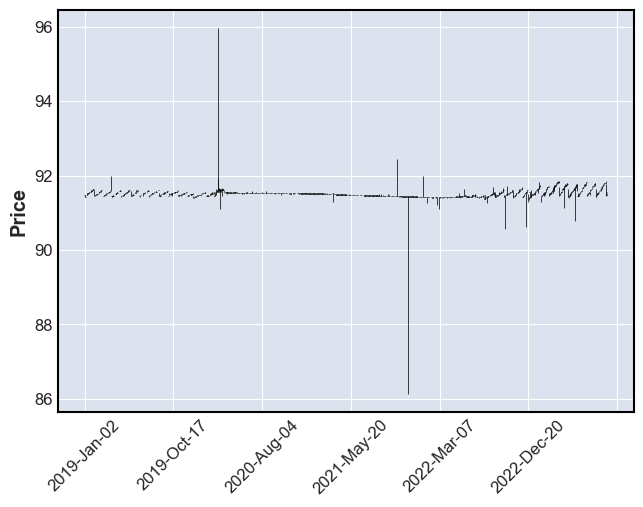

In [29]:
daily = bars.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

In [30]:
all_adjusted = div_adjust(bars, split_adjusted_dividends)

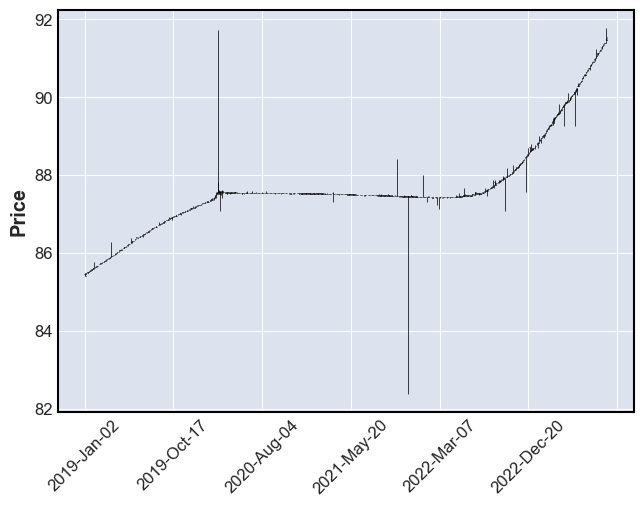

In [31]:
daily = all_adjusted.resample('1D').agg({'open': 'first', 
                                 'high': 'max', 
                                 'low': 'min', 
                                 'close': 'last'})
daily.dropna(inplace=True)
mpf.plot(daily, type='ohlc', show_nontrading=False, warn_too_much_data=1000000)

# 8.4 Reindexing and NA values

When reindexing we need to get a list of all minutes. Since we will also have to do this in the backtester (which loops over the minutes), we will store it and create a function to retrieve it.

In [32]:
market_hours = get_market_calendar()

# Get all minutes from trading days
trading_datetimes = pd.date_range(start=market_hours.index[0], end=datetime.combine(market_hours.index[-1], time(23, 59)), freq='min', name='datetime')

# Remove non-trading days
trading_datetimes = pd.DataFrame(index = trading_datetimes)
trading_datetimes['date'] = trading_datetimes.index.date
trading_datetimes = trading_datetimes[trading_datetimes['date'].isin(market_hours.index)]
trading_datetimes = trading_datetimes.index

# Get early closes
early_closes = market_hours[market_hours['postmarket_close'] != time(19, 59)]

# Filter to all trading minutes in trading days
trading_datetimes = trading_datetimes[(trading_datetimes.time >= time(4)) & (trading_datetimes.time <= time(19, 59))] 

# Remove the minutes in early closes (from 17:00 to 19:59 there is no post-market on early close days)
for date_, early_close in early_closes.iterrows():
    postmarket_close = early_close['postmarket_close']
    trading_datetimes = trading_datetimes[~((trading_datetimes > datetime.combine(date_, early_close['postmarket_close'])) & (trading_datetimes <= datetime.combine(date_, time(19, 59)) ) )] 

trading_datetimes.to_series().to_csv(DATA_PATH + '../market/trading_minutes.csv', index=False)

In [33]:
from functools import lru_cache

# This decorator ensures that when we call a function the output is stored for future calls.
# This is useful is executing the function is expensive and gets called a lot.
@lru_cache
def get_market_minutes():
    trading_datetimes = pd.read_csv(DATA_PATH + '../market/trading_minutes.csv')
    return pd.to_datetime(trading_datetimes['datetime'])

In [34]:
def reindex_and_fill(bars):
    # Get the days the ticker is trading
    ticker_days = np.unique(bars.index.date)
    market_datetimes = get_market_minutes()
    ticker_datetimes = market_datetimes[(market_datetimes.dt.date >= ticker_days[0]) & (market_datetimes.dt.date <= ticker_days[-1])]

    # Reindex
    bars = bars.reindex(ticker_datetimes)

    # Fill NA values
    bars['tradeable'] = ~bars['volume'].isna()
    bars['volume'] = bars['volume'].fillna(value=0) 

    bars["close"] = bars["close"].fillna(method="ffill")
    bars["close_original"] = bars["close_original"].fillna(method="ffill")
    bars["open"] = bars["open"].fillna(bars["close"])
    bars["low"] = bars["low"].fillna(bars["close"])
    bars["high"] = bars["high"].fillna(bars["close"])

    # Only affects the very start. Else backfill shouldn't be used because of look-ahead bias.
    bars["open"] = bars["open"].fillna(method="bfill")
    
    bars["close"] = bars["close"].fillna(bars["open"])
    bars["close_original"] = bars["close_original"].fillna(method='bfill') # Technically we should get the open_original, but I am not going to bother with the untradeable bars at the start that will never be used.
    bars["low"] = bars["low"].fillna(bars["open"])
    bars["high"] = bars["high"].fillna(bars["open"])
    
    return bars

In [35]:
bars = pd.read_parquet(f"{DATA_PATH}raw/m1/BIL-2019-01-01.parquet")
bars, div = split_adjust(bars, "BIL")
bars = reindex_and_fill(bars)

In [36]:
bars.tail(3)

,open,high,low,close,close_original,volume,tradeable
datetime,,,,,,,
2023-09-07 19:57:00,91.5304,91.5304,91.5304,91.5304,91.5304,1000.0,True
2023-09-07 19:58:00,91.5304,91.5304,91.5304,91.5304,91.5304,0.0,False
2023-09-07 19:59:00,91.5304,91.5304,91.5304,91.5304,91.5304,0.0,False


# 8.5 Halt detection
We cannot detect all halts without tick data. However we are not interested in pre- and post-market halts anyways. We care about the liquid stocks that are halted intraday and have decent volume. Halts take a minimum of 5 minutes. This means at least 4 OHLC 1-minutes bars with no data, because a halt can start *during* the OHLC bar.

For each stock where the turnover is more than 2.5 million dollars we will check whether there are 4 empty bars during regular hours. Illiquid stocks do not trade all minutes and may be incorrectly flagged. This happens quite often making the 'halted' flag useless. Currently 'halted' only means 'suspicious'.

The best way to do this is to flag all 'suspicious' empty periods and check with tick data if the quotes dissapear. However I do not yet have access to tick data. When we have tick data, we can just loop over the minutes with a 'halted' flag True and check if there exist quotes. 

In [37]:
# bars = pd.read_parquet(DATA_PATH + f"processed/m1/TOP-2022-06-01.parquet")
# dump = bars[(bars.index >= datetime(2023, 5, 4, hour=10, minute=45)) & (bars.index <= datetime(2023, 5, 4, hour=11, minute=8))].copy()
# dump = dump.drop(columns=['halted'])

# mpf.plot(dump, type='candle', style='yahoo', show_nontrading=False, title="TOP intraday halts on 2023-05-04")

It is handy to first create a function to remove the non-regular market hours from the minute bars.

In [38]:
def remove_extended_hours(bars):
    """
    Remove extended hours.
    """
    # Remove non-regular trading minutes. Only the post-market hours of early closes remain.
    bars = bars[['close', 'volume', 'tradeable']].copy()
    bars = bars.between_time('9:30', '15:59')

    # Remove early close post-market bars
    market_hours = get_market_calendar()
    early_closes = market_hours[market_hours['regular_close'] != time(15, 59)]
    for date_, early_close in early_closes.iterrows():
        bars = bars[~((bars.index > datetime.combine(date_, early_close['regular_close'])) & (bars.index <= datetime.combine(date_, time(19, 59)) ) )] 
        
    return bars

In [39]:
def flag_halts(bars):
    """
    Only flags intraday halts for stocks >2.5M turnover. May get false-positive if there is low volume.
    """
    bars_halted = remove_extended_hours(bars)
    bars_halted = bars_halted[["close", "volume", "tradeable"]]
    
    # Filter for volume
    # To reduce false-positives, also filter for stocks that had at least 240 minutes of trading during regular hours.
    daily = bars_halted[['volume', 'close', 'tradeable']].resample('D').agg({'volume': 'sum', 'close': 'last', 'tradeable': 'sum'})
    daily['turnover'] = daily['volume'] * daily['close']
    daily = daily[(daily['turnover'] > 2_500_000) & (daily['tradeable'] > 240)]
    has_volume = daily.index.date

    bars_halted['date'] = bars_halted.index.date
    bars_halted = bars_halted[bars_halted['date'].isin(has_volume)]

    # Flag if 4x untradeable one after another. Only the 4-th (and lager) occasion is flagged.
    bars_halted['halted_for_4+'] = (~bars_halted["tradeable"]).rolling(4).sum() >= 4
    # Also flag the 1st, 2nd and 3rd occasion.
    bars_halted['halted'] = bars_halted['halted_for_4+'].replace(to_replace=False, method='bfill', limit=3)

    bars = bars.merge(bars_halted['halted'], how='left', left_index=True, right_index=True)
    bars['halted'] = bars['halted'].fillna(False)
    return bars

In [40]:
#flag_halts(dump).tail(10)

# 8.6 Putting it all in a loop
It took me 8 hours to run. The files take up 35GB for data from 2019-01-01 to 2023-09-01.

**Manually fixed errors in adjustments**

* In the files RETO had a 10-to-1 split on 2023-05-12 and 2023-05-15. The 2023-05-15 one is a duplicate and is removed manually. 

In [41]:
# # https://mattgosden.medium.com/rounding-to-significant-figures-in-python-2415661b94c3
# from math import floor, log10

# def sig_figs(x: float, precision: int):
#     """
#     Rounds a number to number of significant figures
#     Parameters:
#     - x - the number to be rounded
#     - precision (integer) - the number of significant figures
#     Returns:
#     - float
#     """
#     if x == 0.0:
#         return x
    
#     x = float(x)
#     precision = int(precision)

#     return round(x, -int(floor(log10(abs(x)))) + (precision - 1))

In [42]:
all_files = os.listdir(f'{DATA_PATH}raw/m1/')
for index, file in enumerate(all_files):
    ticker = file[:-19] # Remove date and parquet extension
    bars = pd.read_parquet(f"{DATA_PATH}raw/m1/{file}")
    
    # CLEANING
    # I do not have tick data yet. However this is how you would do it if you got a csv of the cleaned bars only.
    # if os.path.isfile(DATA_PATH + f"raw/cleaned/{ticker}.csv"):
    #     clean_bars = pd.read_csv(DATA_PATH + f"raw/cleaned/{ticker}.csv", parse_dates=True, index_col=0)
    #     bars.update(clean_bars)

    # ADJUSTING
    split_adjusted_bars, split_adjusted_dividends = split_adjust(bars, ticker)
    all_adjusted = div_adjust(split_adjusted_bars, split_adjusted_dividends)

    # FORWARD FILLING
    all_adjusted = reindex_and_fill(all_adjusted)
    
    # HALT DETECTION
    all_adjusted = flag_halts(all_adjusted)

    # # ROUNDING: TO 6 SIGNIFICANT FIGURES (extremely slow)
    # all_adjusted_bars['open'] = all_adjusted_bars['open'].apply(lambda x: sig_figs(x, 6))
    # all_adjusted_bars['high'] = all_adjusted_bars['high'].apply(lambda x: sig_figs(x, 6))
    # all_adjusted_bars['low'] = all_adjusted_bars['low'].apply(lambda x: sig_figs(x, 6))
    # all_adjusted_bars['close'] = all_adjusted_bars['close'].apply(lambda x: sig_figs(x, 6))
    # all_adjusted_bars['volume'] = all_adjusted_bars['volume'].apply(lambda x: sig_figs(x, 6))

    # ROUNDING: TO 4 DECIMALS, VOLUME TO INT
    all_adjusted = round(all_adjusted, 4)
    all_adjusted['volume'] = all_adjusted['volume'].astype(int)
    
    all_adjusted.to_parquet(DATA_PATH + f"processed/m1/{file}", engine="fastparquet", row_group_offsets=25000)

    # Saves 40% of space, but takes longer
    #all_adjusted.to_parquet(DATA_PATH + f"processed/m1 (pyarrow brotli)/{file}", engine="pyarrow", compression="brotli", row_group_size=25000)
    print(ticker)

AABA


In [ ]:
# For timing
for i in range(100):
    bars = pd.read_parquet(DATA_PATH + f"processed/m1/AAPL-2019-01-01.parquet")

# 8.7 Updating the ticker list
Now that we have the data, we can add two columns <code>start_data</code> and <code>end_data</code>.

In [ ]:
import pyarrow as pa
import pyarrow.parquet as pq

all_files = os.listdir(DATA_PATH + f'raw/m1/')
tickers_v3 = get_tickers(v=3)
tickers_v3["start_data"] = np.nan
tickers_v3["end_data"] = np.nan
tickers_v3.set_index(tickers_v3['ID'], inplace=True)
tickers_v3.drop(columns="ID", inplace=True)

for index, file in enumerate(all_files):
    id = file[:-8] # Remove parquet extension

    dataset = pq.ParquetFile(DATA_PATH + f"processed/m1/{file}")

    # Reidigidddddddddddddsssssssssdad metadata (statistics) of first and last row group. This avoids reading the entire file.
    # Reading everything from the datetime column and getting first/last row took 8 minutes. This took less than 50 sec.
    metadata_first_row_group = dataset.metadata.row_group(0)
    metadata_last_row_group = dataset.metadata.row_group(dataset.num_row_groups-1)
    # Retrieve statistics
    min_date = metadata_first_row_group.column(0).statistics.min
    max_date = metadata_last_row_group.column(0).statistics.max
    # Convert to date
    start_data = min_date.to_pydatetime().date()
    end_data = max_date.to_pydatetime().date()
    
    tickers_v3.loc[id, ["start_data", "end_data"] ] = [start_data, end_data]

    print(index)

tickers_v3.reset_index(inplace=True)
tickers_v3[["ID", "ticker", "name", "active", "start_date", "end_date", "start_data", "end_data", "type", "cik", "composite_figi"]].to_csv("../data/tickers_v4.csv")

In [ ]:
tickers_v4 = get_tickers(v=4)
tickers_v4['start_data'] = pd.to_datetime(tickers_v4['start_data']).dt.date
tickers_v4['end_data'] = pd.to_datetime(tickers_v4['end_data']).dt.date
tickers_v4.iloc[:3, :9].head(3)

,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
0,A-2019-01-01,A,Agilent Technologies Inc.,True,2019-01-01,2023-09-07,2019-01-02,2023-09-07,CS
1,AA-2019-01-01,AA,Alcoa Corporation,True,2019-01-01,2023-09-07,2019-01-02,2023-09-07,CS
2,AABA-2019-01-01,AABA,Altaba Inc. Common Stock,False,2019-01-01,2019-10-04,2019-01-02,2019-10-02,CS


Some stocks have zero data. There are the tickers with only ghost days. We can safely remove those.

In [ ]:
zero_data = tickers_v4[(tickers_v4['start_data'].isna() & (tickers_v4['type'] != "INDEX"))]
print(len(zero_data))
zero_data.iloc[:3, :9].head(3)

38


,ID,ticker,name,active,start_date,end_date,start_data,end_data,type
106,ACRV-2022-11-10,ACRV,"Acrivon Therapeutics, Inc. Common Stock",False,2022-11-10,2022-11-11,NaT,NaT,CS
177,AEON-2021-10-08,AEON,"AEON Biopharma, Inc. Common Stock",False,2021-10-08,2021-10-13,NaT,NaT,CS
195,AFCG-2021-02-11,AFCG,"AFC Gamma, Inc. Common Stock",False,2021-02-11,2021-02-18,NaT,NaT,CS


In [ ]:
tickers_v4 = tickers_v4[~(tickers_v4['start_data'].isna() & (tickers_v4['type'] != "INDEX"))]
tickers_v4.reset_index(inplace=True, drop=True)
tickers_v4.to_csv("../data/tickers_v4.csv")

# 8.8 Updates
Not implemented. However, we should only process the tickers that had splits/divs in the update period. The rest only has to be reindex/filled+flagged. Then appended.